# Measuring connectivity of graph partitions

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy.api as sc
from scanpy.api import Neighbors
import pandas as pd
import seaborn as sns
import igraph
from scanpy.tools.paga import PAGA
from numpy.random import choice
from scipy.sparse import csr_matrix, coo_matrix
from sklearn.datasets import make_blobs
from scipy.stats import norm
from scipy.special import binom, factorial

np.random.seed(0)
sc.logging.print_versions()
sc.set_figure_params(vector_friendly=False)
figsuffix = ''

scanpy==1.2.0 anndata==0.6.4+6.gd9727ca numpy==1.13.1 scipy==1.0.0 pandas==0.22.0 scikit-learn==0.19.1 statsmodels==0.9.0 python-igraph==0.7.1 louvain==0.6.1 


## Some function definitions as in the paper

In [7]:
def prob_epsilon_arbit_degree_knn(epsilon, n, ni, n_neighbors):
    nj = n - ni
    ei = (n_neighbors - 1) * ni
    ej = (n_neighbors - 1) * nj
    return prob_epsilon_arbit_degree(epsilon, ei, ej, ni, nj)

def epsilon_hat_arbit_degree_knn(n, ni, n_neighbors):
    nj = n - ni
    ei = (n_neighbors - 1) * ni
    ej = (n_neighbors - 1) * nj
    return (ei*nj + ej*ni)/(ni + nj - 1)

def sigma_hat_arbit_degree_knn(n, ni, n_neighbors):
    nj = n - ni
    ei = (n_neighbors - 1) * ni
    ej = (n_neighbors - 1) * nj
    return np.sqrt((ei*nj*(ni-1) + ej*ni*(nj-1))/(ni + nj - 1)/(ni + nj - 1))

def prob_epsilon_arbit_degree_knn_gauss(epsilon, n, ni, n_neighbors):
    p = norm.pdf(
        epsilon,
        epsilon_hat_arbit_degree_knn(n, ni, n_neighbors),
        sigma_hat_arbit_degree_knn(n, ni, n_neighbors))
    return p

def prob_epsilon_arbit_degree(epsilon, ei, ej, ni, nj):
    denom = (1 + nj/(ni-1))**ei * (1 + ni/(nj-1))**ej
    def summand(eps):
        if (ei - eps) < 0 or (ej - eps) < 0:
            return 0
        return binom(ei, eps) * ((nj)/(ni-1))**eps * binom(ej, epsilon-eps) * ((ni)/(nj-1))**(epsilon-eps)
    num = np.sum([summand(eps) for eps in range(0, epsilon+1)])
    return num/denom

def prob_epsilon_const_degree(epsilon, hi, hj):
    def factor(eps, hi, hj):
        if not (0.5*(hi+hj)).is_integer():
            return 0
        if not (0.5*(hi-eps)).is_integer():
            return 0
        if 0.5*(hi+hj) < eps or (0.5*(hi+hj) - eps) < 0.5*(hi-eps):
            return 0
        num = 2**eps * binom(0.5*(hi+hj), eps) * binom(0.5*(hi+hj) - eps, 0.5*(hi-eps))
        denom = binom(hi + hj, hj)
        return num/denom
    return np.sum([factor(eps, hi, hj)*factor(epsilon-eps, hj, hi) for eps in range(0, epsilon+1)])

def compute_connectivities(adata, model='v1.2'):
    paga = PAGA(adata, 'partitions', model=model)
    return paga.compute_connectivities()

def generate_bipartitioned_random_graph_knn(
    n, n_neighbors, resolution, cluster_dist=0, random_state=0, labels_ordered=None, n_var=20):
    first_center = np.zeros(n_var, dtype=np.float32)
    second_center = np.zeros(n_var, dtype=np.float32)
    second_center[0] = cluster_dist
    centers = np.array([first_center, second_center])
    X, _ = make_blobs(
        n_samples=n, centers=centers, n_features=n_var, random_state=random_state)
    adata = sc.AnnData(X)
    sc.pp.neighbors(adata, n_neighbors=n_neighbors)
    if resolution == 0:
        labels = choice(labels_ordered, size=len(labels_ordered), replace=False).astype(str)
        adata.obs['partitions'] = labels
        if n_realizations <= 10:
            sc.tl.draw_graph(adata)
            sc.pl.draw_graph(adata, color='partitions', title='random partitions', edges=True, size=100, legend_loc='none', save=figsuffix)
    else:
        found_2_clusters = False
        for rs in range(10):
            sc.tl.louvain(adata, resolution=resolution, key_added='partitions', random_state=rs)
            if len(adata.obs['partitions'].cat.categories) == 2:
                found_2_clusters = True
                break
        if n_realizations <= 10:
            sc.tl.draw_graph(adata)
            sc.pl.draw_graph(adata, color='partitions', title='Louvain partitions', edges=True, size=100, legend_loc='none', save=figsuffix)
        if not found_2_clusters:
            return None
    return adata

def generate_bipartitioned_random_graph_const_degree(n, ni, n_neighbors, labels_ordered):
    nj = n - ni
    hi = (n_neighbors - 1) * ni
    hj = (n_neighbors - 1) * nj    
    if n_neighbors != 2:
        raise ValueError('n_neighbors != 2 is not implemented for \'const_degree\'')
    if (hi%2 != 0 or hj%2 !=0):
        raise ValueError('Only even number of half edges are allowed.')
    A_sum = np.zeros((n, n), dtype=int)
    for i in range(2):
        A = np.zeros((n, n), dtype=int)
        es = np.arange(hi + hj, dtype=int)
        sequence = choice(es, replace=False, size=len(es))
        lenes2 = int(len(es)/2)
        A[sequence[:lenes2], sequence[lenes2:]] = 1
        A_sum += A
    A_sum = csr_matrix(A_sum)
    A_sum.eliminate_zeros()
    A_conn = A_sum + A_sum.T - A_sum.multiply(A_sum.T)
    adata = sc.AnnData(X=np.zeros((n, 2)),
                       obs={'partitions': labels_ordered.astype(str)},
                       uns={'neighbors': {'distances': A_sum, 'connectivities': A_conn}})
    if n_realizations < 10:
        sc.tl.draw_graph(adata)
        sc.pl.draw_graph(adata, color='partitions', edges=True, size=100)
    return adata

def generate_bipartitioned_random_graph(
    n, ni, n_neighbors, mode='knn', resolution=0, cluster_dist=0, random_state=0):
    """`resolution=0` means random partitions"""
    labels_ordered = np.concatenate([np.ones(ni, dtype=int), np.zeros(n - ni, dtype=int)])    
    if mode == 'knn':
        adata = generate_bipartitioned_random_graph_knn(
            n, n_neighbors, resolution,
            cluster_dist=cluster_dist, labels_ordered=labels_ordered,
            random_state=random_state)
    elif mode == 'const_degree':
        adata = generate_bipartitioned_random_graph_const_degree(
            n, ni, n_neighbors, labels_ordered)
    else:
        raise ValueError('`mode` is unknown')
    if adata is None:
        return adata
    adata.obs['partitions'] = adata.obs['partitions'].astype('category')        
    return adata

def estimate_probability(
    n, ni, n_neighbors, cluster_dist=0, resolution=0, model='v1.2', mode='knn', random_state=0, return_all=False):

    epsilon_observed = []
    conn_observed = []
    ni_observed = []
    for i in range(n_realizations):
        if ni == 0:
            ni_sim = np.random.randint(1, int(n/2+1)+1)
        else:
            ni_sim = ni
        adata = generate_bipartitioned_random_graph(
            n, ni_sim, n_neighbors,
            cluster_dist=cluster_dist,
            resolution=resolution,
            mode=mode, random_state=i)
        if adata is None:
            continue
        inter_es, connectivity = compute_connectivities(adata, model=model)
        epsilon_observed.append(inter_es[0, 1])
        conn_observed.append(connectivity[0, 1])
        ni_obs = adata.obs.groupby('partitions').size()[0]
        if ni_obs > n/2:
            ni_obs = n - ni_obs
        ni_observed.append(ni_obs)
    
    hist, bins = np.histogram(epsilon_observed, bins=np.arange(-0.5, (n_neighbors-1)*n+1))
    epsilon_estim = hist / n_realizations
   
    hist, conn_bins = np.histogram(conn_observed, bins=np.arange(0, 1.02, 0.02))
    conn_estim = hist / n_realizations
    
    hist, ni_bins = np.histogram(ni_observed)
    ni_estim = hist / n_realizations
    
    if return_all:
        return epsilon_observed, epsilon_estim, conn_observed, conn_estim, conn_bins, ni_observed, ni_estim, ni_bins
    else:
        return epsilon_estim

## Test random model for const-degree and knn graphs

In [8]:
n_realizations = 1000
n = 10
n_neighbors = 2
ni = 4
nj = n - ni
ei = (n_neighbors - 1) * ni
ej = (n_neighbors - 1) * nj

p_estim_const = estimate_probability(n, ni, n_neighbors, mode='const_degree')
p_estim_knn = estimate_probability(n, ni, n_neighbors, mode='knn')
p_estim_umap = estimate_probability(n, ni, n_neighbors, mode='knn', model='v1.0')

p_pred_const = [prob_epsilon_const_degree(epsilon, ei, ej) for epsilon in np.arange(ei+ej+1, dtype=int)]
p_pred_arbit = [prob_epsilon_arbit_degree(epsilon, ei, ej, ni, nj) for epsilon in np.arange(ei+ej+1, dtype=int)]

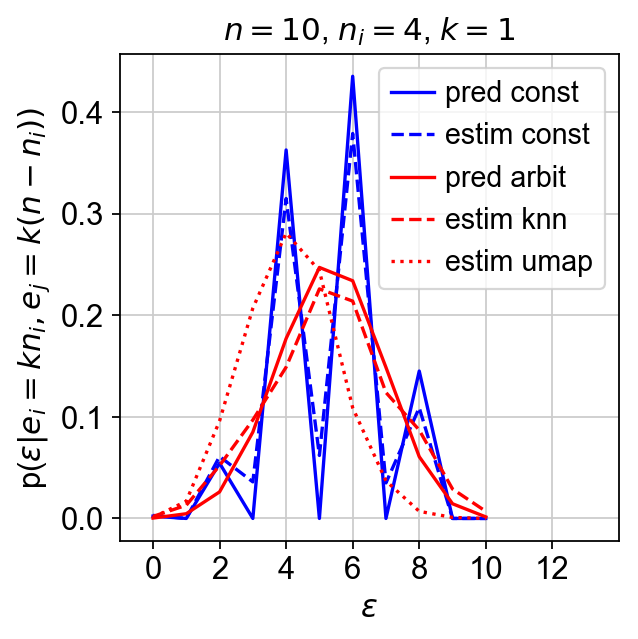

In [119]:
pl.figure()
pl.plot(p_pred_const, 'b', label='pred const')
pl.plot(p_estim_const, '--b', label='estim const')
pl.plot(p_pred_arbit, 'r', label='pred arbit')
pl.plot(p_estim_knn, '--r', label='estim knn')
pl.plot(p_estim_umap, ':r', label='estim umap')
pl.legend(handlelength=1.5)
pl.title(r'$n={}$, $n_i={}$, $k={}$'.format(n, ni, n_neighbors-1))
pl.ylabel(r'p($\varepsilon|e_i=kn_i, e_j=k(n-n_i))$')
pl.xlabel(r'$\varepsilon$')
pl.xticks(np.arange(0, 14, 2, dtype=int))
pl.xlim(-1, 14)
pl.savefig('./figures/compare_const_arbit_n10.pdf', bbox_inches='tight')
pl.show()

Look at a somewhat larger graph.

In [5]:
n_realizations = 1000
n = 100
n_neighbors = 2
ni = 40
nj = n - ni
ei = (n_neighbors - 1) * ni
ej = (n_neighbors - 1) * nj

p_estim_const = estimate_probability(n, ni, n_neighbors, mode='const_degree')
p_estim_knn = estimate_probability(n, ni, n_neighbors, mode='knn')
p_estim_umap = estimate_probability(n, ni, n_neighbors, mode='knn', model='v1.0')

p_pred_const = [prob_epsilon_const_degree(epsilon, ei, ej) for epsilon in np.arange(n*(n_neighbors-1)+1, dtype=int)]
p_pred_arbit = [prob_epsilon_arbit_degree(epsilon, ei, ej, ni, nj) for epsilon in np.arange(n*(n_neighbors-1)+1, dtype=int)]

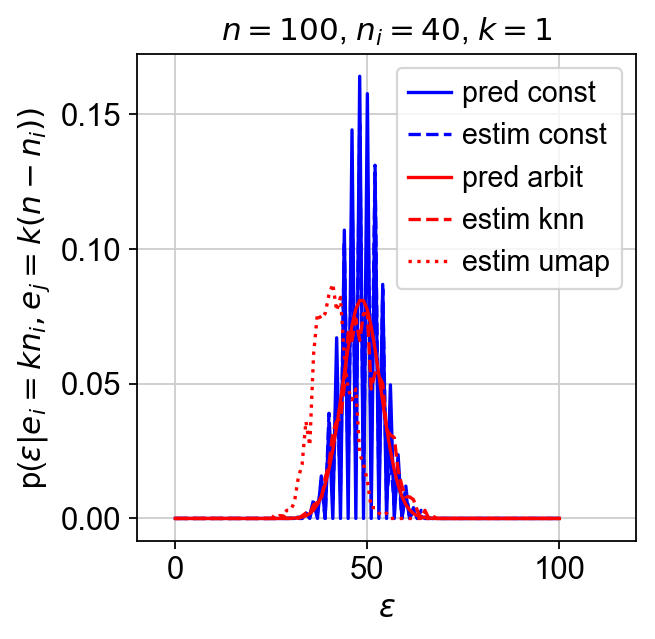

In [122]:
pl.figure()
pl.plot(p_pred_const, 'b', label='pred const')
pl.plot(p_estim_const, '--b', label='estim const')
pl.plot(p_pred_arbit, 'r', label='pred arbit')
pl.plot(p_estim_knn, '--r', label='estim knn')
pl.plot(p_estim_umap, ':r', label='estim umap')
pl.legend(handlelength=1.5)
pl.title(r'$n={}$, $n_i={}$, $k={}$'.format(n, ni, n_neighbors-1))
pl.ylabel(r'p($\varepsilon|e_i=kn_i, e_j=k(n-n_i))$')
pl.xlabel(r'$\varepsilon$')
pl.xlim(-10, 120)
pl.savefig('./figures/compare_const_arbit_n100.pdf', bbox_inches='tight')
pl.show()

Effect of $k$ (`n_neighbors`).

In [4]:
n_realizations = 1000
n = 100
ni = 40

n_neighbors = 6
p_estim_knn1 = estimate_probability(n, ni, n_neighbors, mode='knn')
p_estim_umap1 = estimate_probability(n, ni, n_neighbors, mode='knn', model='v1.0')
p_pred_arbit1 = [prob_epsilon_arbit_degree_knn_gauss(epsilon, n, ni, n_neighbors)
                 for epsilon in np.arange(n*(n_neighbors-1)+1, dtype=int)]

n_neighbors = 11
p_estim_knn2 = estimate_probability(n, ni, n_neighbors, mode='knn')
p_estim_umap2 = estimate_probability(n, ni, n_neighbors, mode='knn', model='v1.0')
p_pred_arbit2 = [prob_epsilon_arbit_degree_knn_gauss(epsilon, n, ni, n_neighbors)
                 for epsilon in np.arange(n*(n_neighbors-1)+1, dtype=int)]

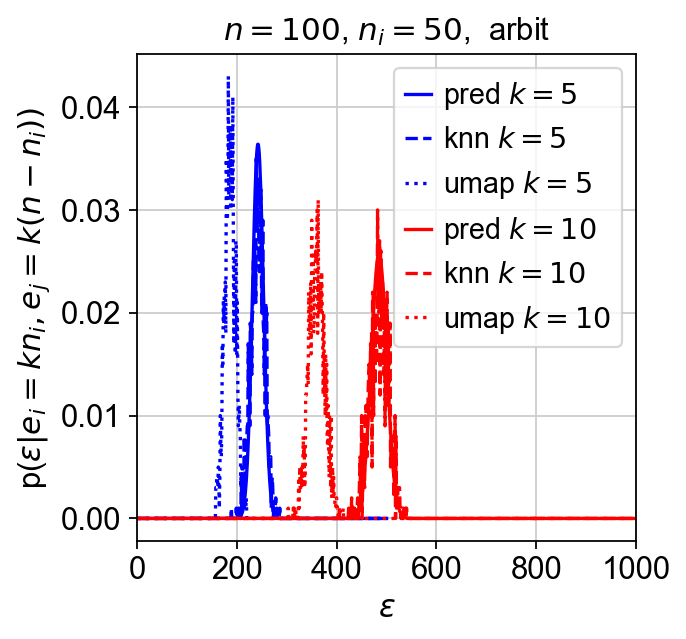

In [9]:
pl.figure()
pl.plot(p_pred_arbit1, 'b', label='pred $k=5$')
pl.plot(p_estim_knn1, '--b', label='knn $k=5$')
pl.plot(p_estim_umap1, ':b', label='umap $k=5$')
pl.plot(p_pred_arbit2, 'r', label='pred $k=10$')
pl.plot(p_estim_knn2, '--r', label='knn $k=10$')
pl.plot(p_estim_umap2, ':r', label='umap $k=10$')
pl.legend(handlelength=0.9)
pl.title(r'$n={}$, $n_i={}$,  arbit'.format(n, ni, n_neighbors-1))
pl.ylabel(r'p($\varepsilon|e_i=kn_i, e_j=k(n-n_i))$')
pl.xlabel(r'$\varepsilon$')
pl.xlim(0, 1000)
pl.savefig('./figures/compare_ks.pdf', bbox_inches='tight')
pl.show()

Effect of $n_i$.

In [7]:
n = 100
n_neighbors = 6
ni_range = np.arange(10, 60, 10)
p_preds = [None for ni in ni_range]

for i, ni in enumerate(ni_range):
    p_preds[i] = [prob_epsilon_arbit_degree_knn_gauss(
        epsilon, n, ni, n_neighbors) for epsilon in np.arange(n*(n_neighbors-1)+1, dtype=int)]

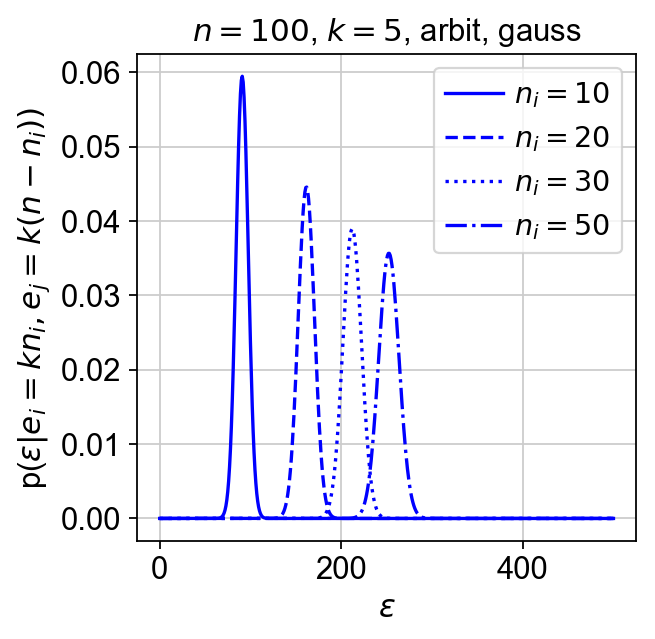

In [10]:
pl.figure()
pl.plot(p_preds[0], 'b', label='$n_i=10$')
pl.plot(p_preds[1], '--b', label='$n_i=20$')
pl.plot(p_preds[2], ':b', label='$n_i=30$')
pl.plot(p_preds[4], '-.b', label='$n_i=50$')
pl.legend(handlelength=2)
pl.title(r'$n={}$, $k={}$, arbit, gauss'.format(n, n_neighbors-1))
pl.ylabel(r'p($\varepsilon|e_i=kn_i, e_j=k(n-n_i))$')
pl.xlabel(r'$\varepsilon$')
pl.savefig('./figures/compare_nis.pdf', bbox_inches='tight')
pl.show()

## Test model for Louvain partitions and mixture of two Gaussians

In [10]:
n = 100
n_neighbors = 4

In [11]:
ni = 50
p_pred_random = [
    prob_epsilon_arbit_degree_knn_gauss(epsilon, n, ni, n_neighbors) for epsilon in range(n*(n_neighbors-1)+1)]

... storing 'partitions' as categorical
saving figure to file ./figures/draw_graph_fa_random.pdf


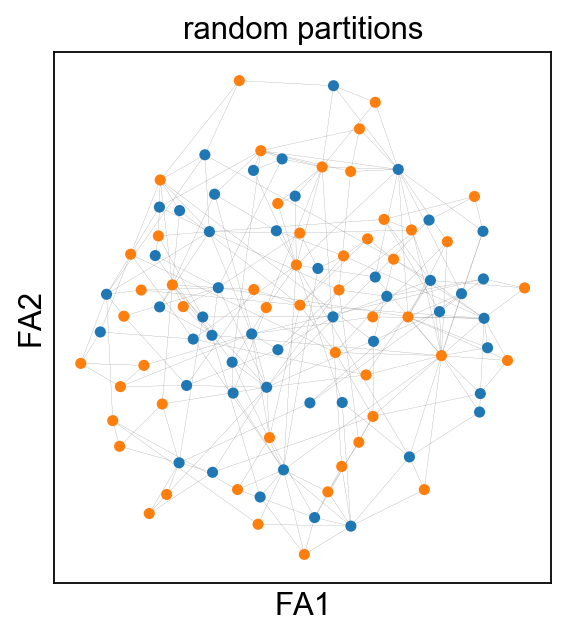

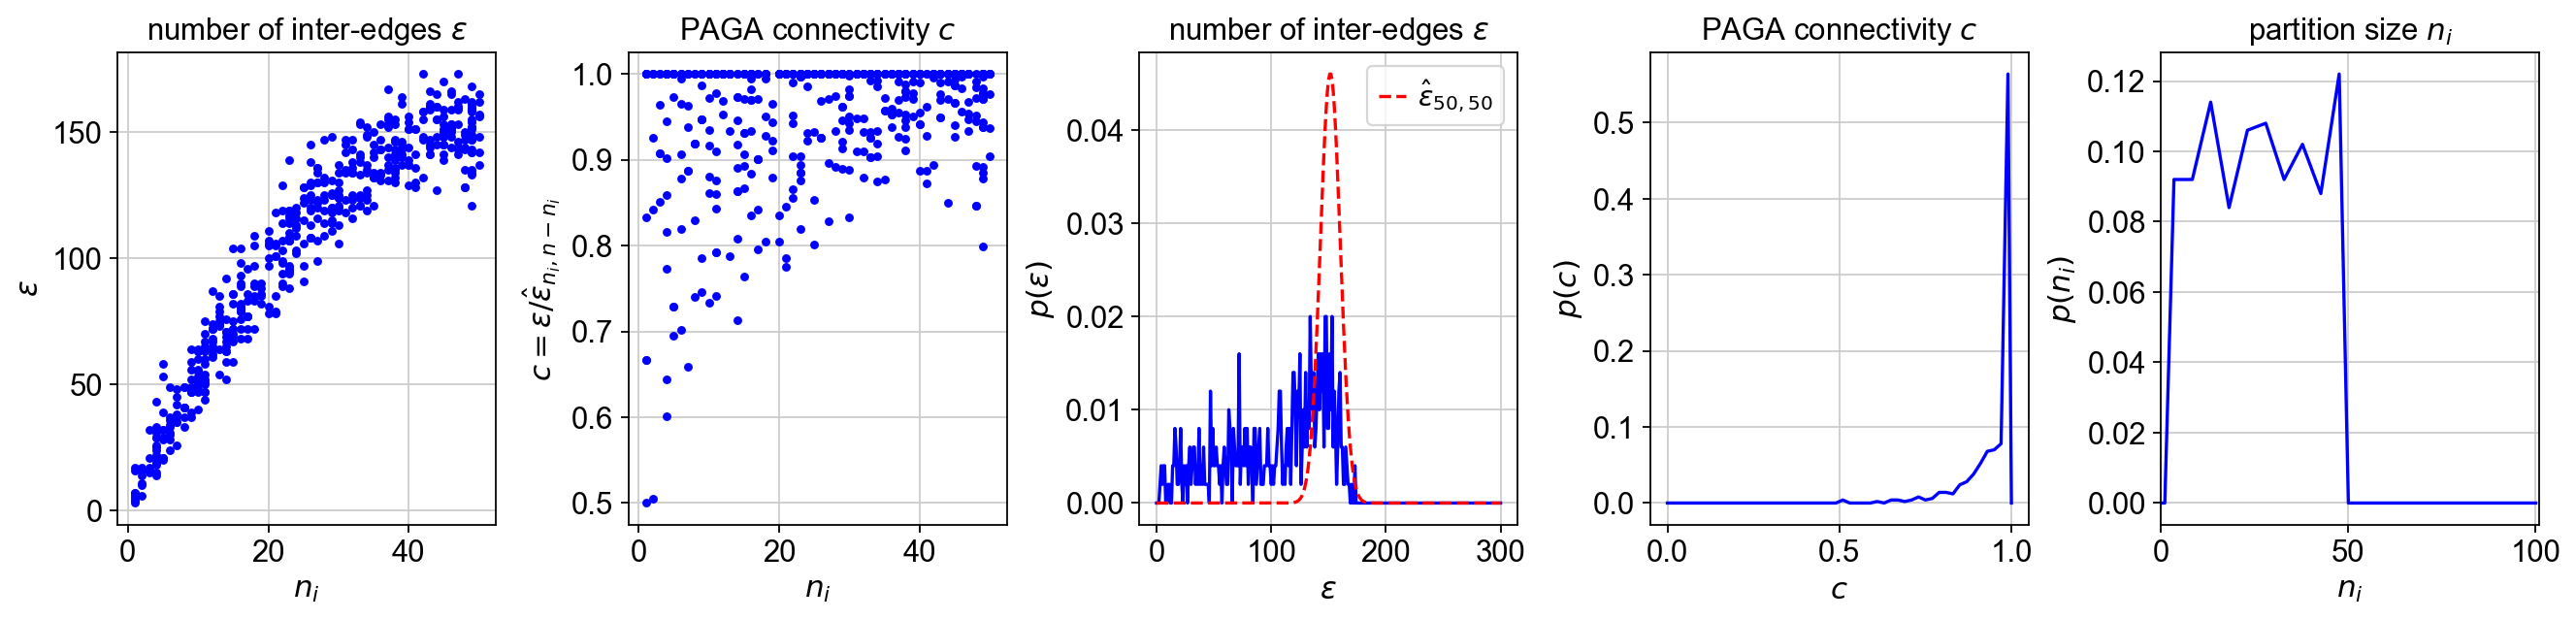

saving figure to file ./figures/draw_graph_fa_dist0.pdf


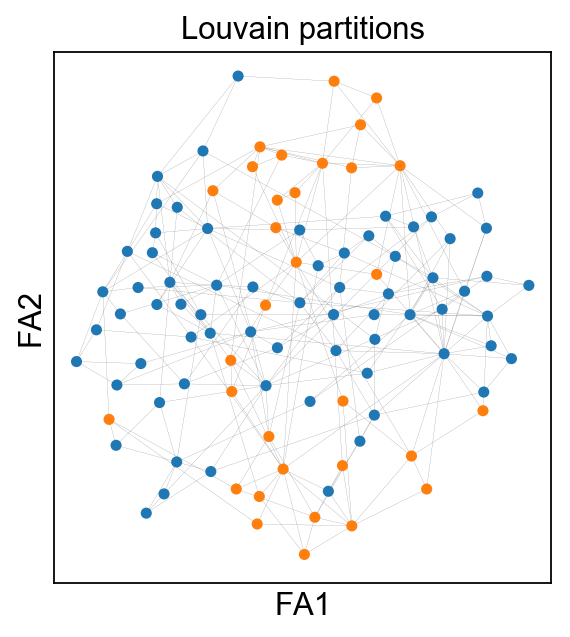

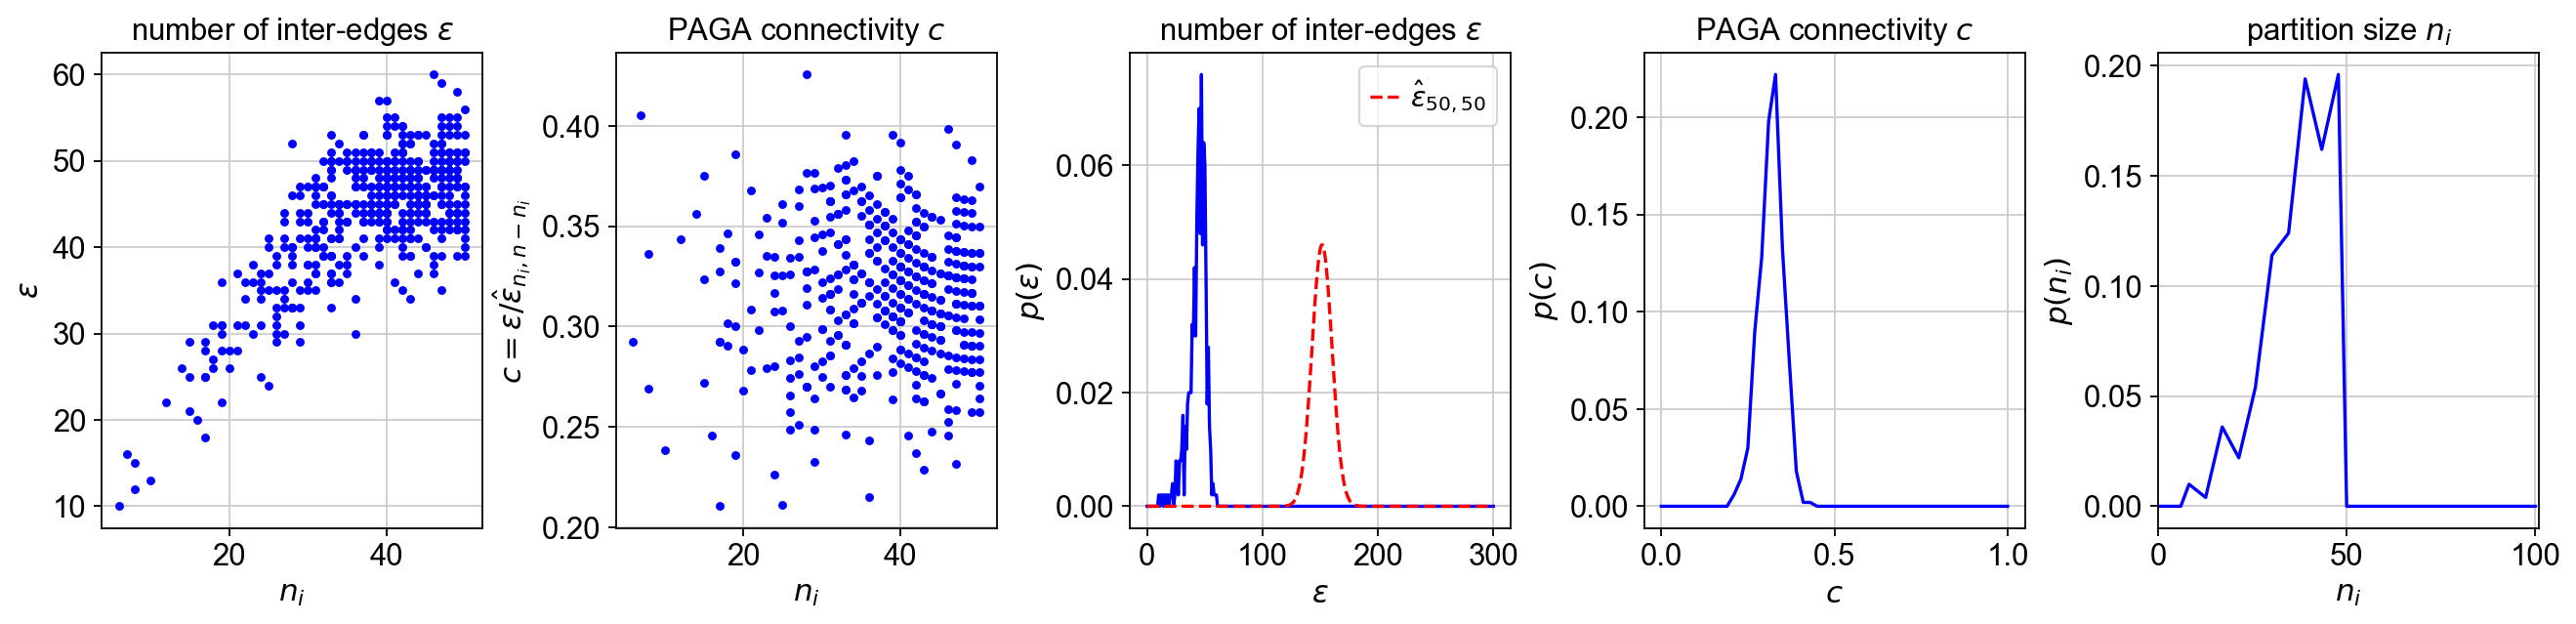

saving figure to file ./figures/draw_graph_fa_dist2.pdf


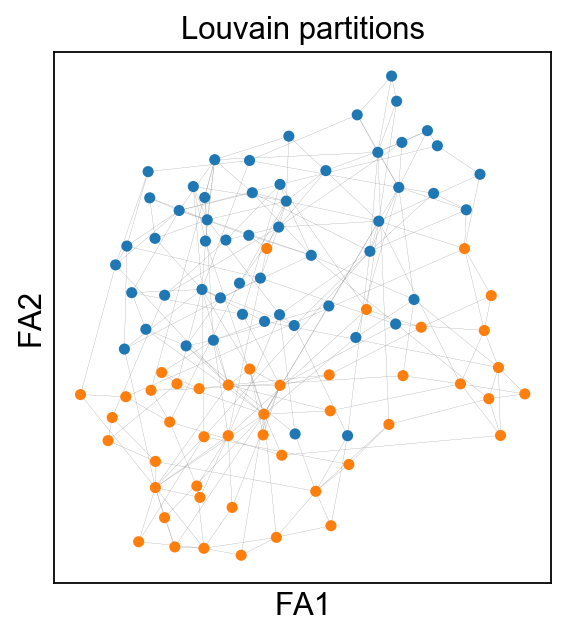

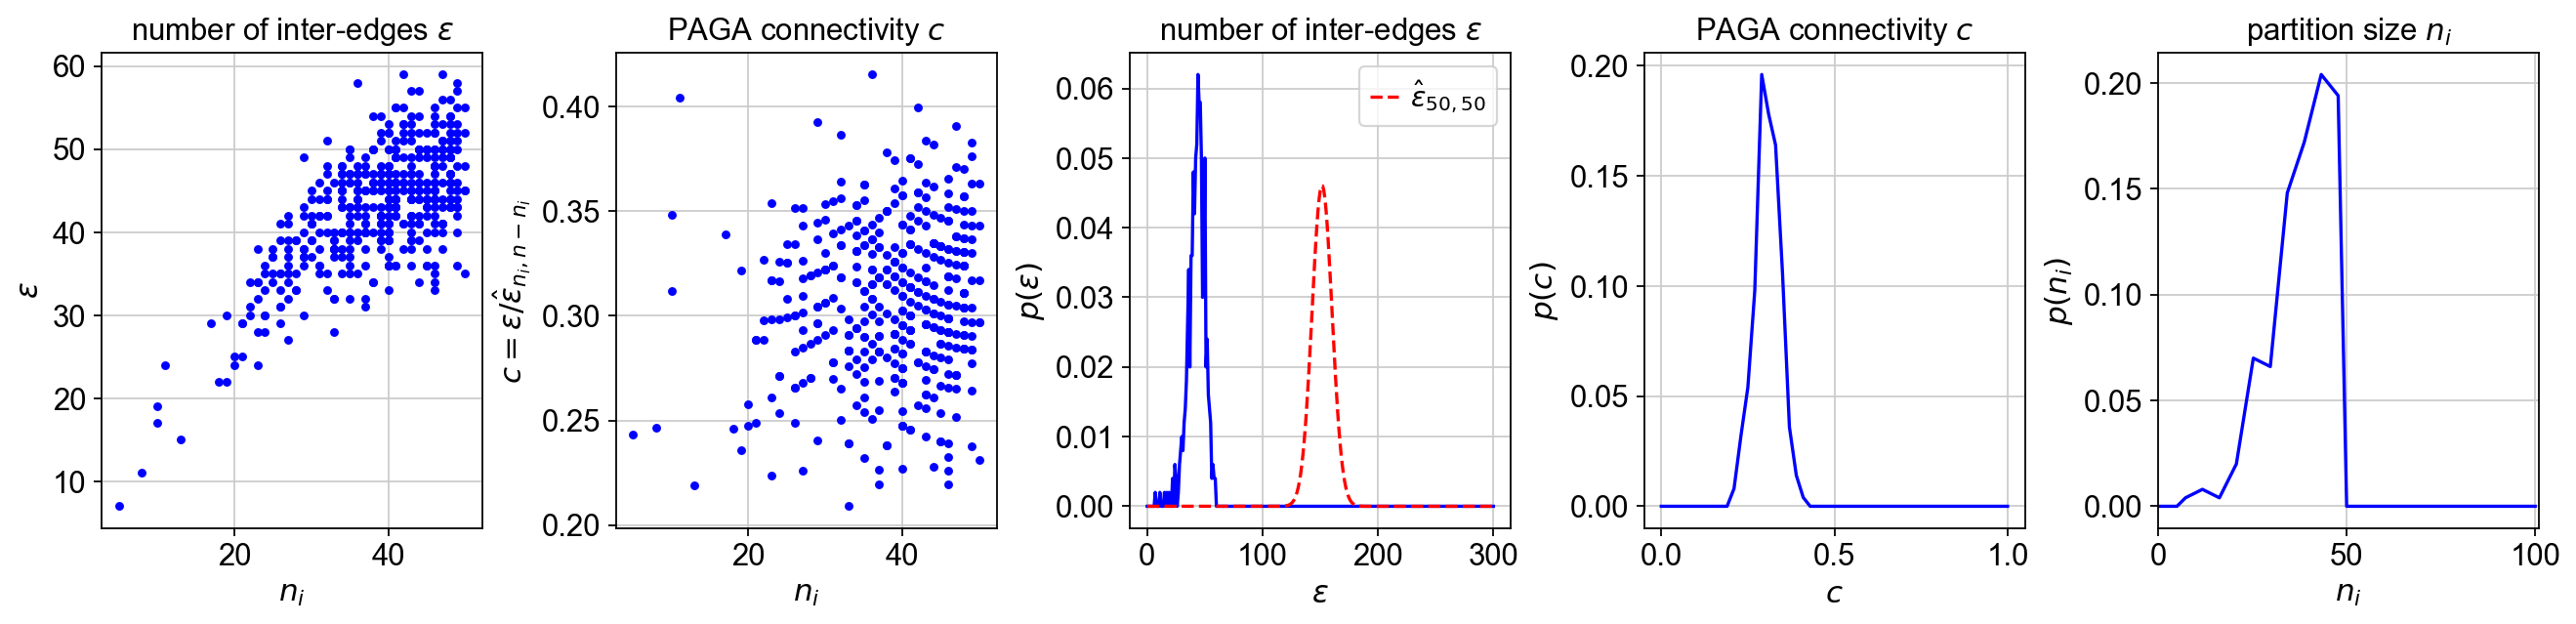

saving figure to file ./figures/draw_graph_fa_dist4.pdf


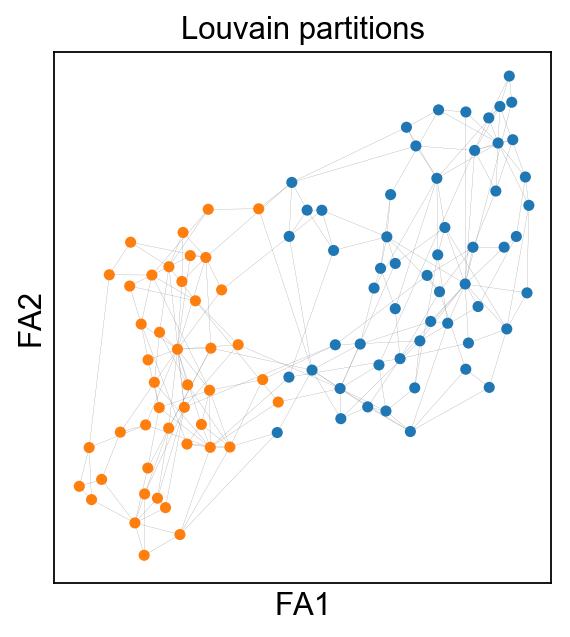

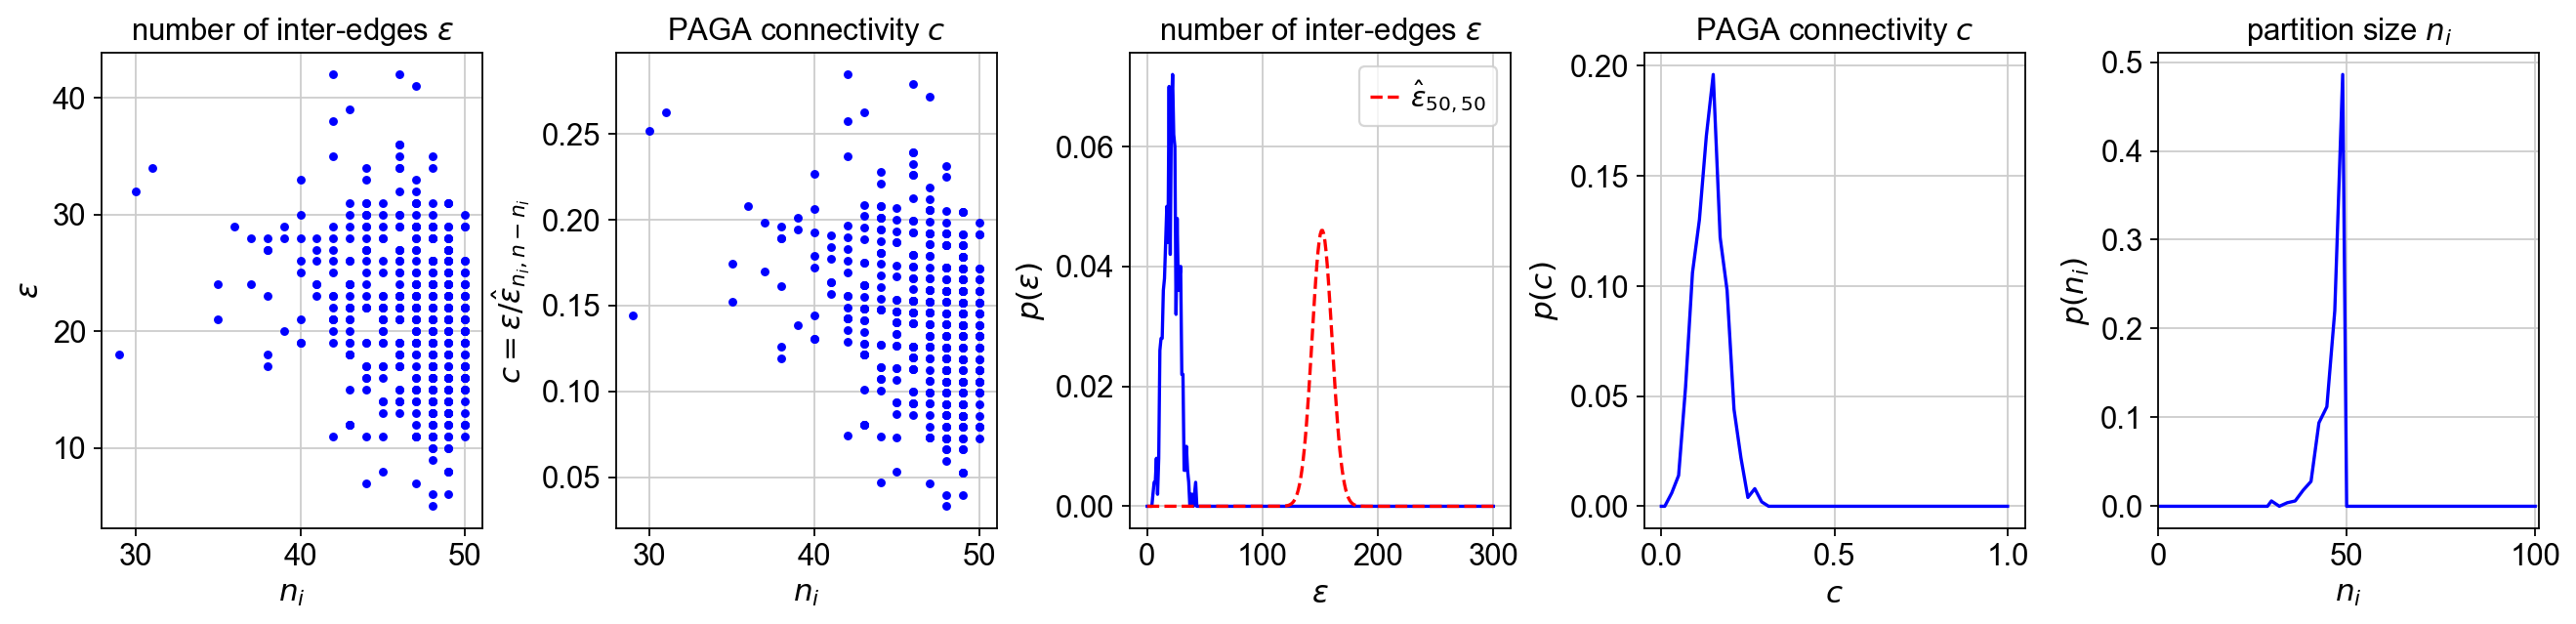

saving figure to file ./figures/draw_graph_fa_dist5.pdf


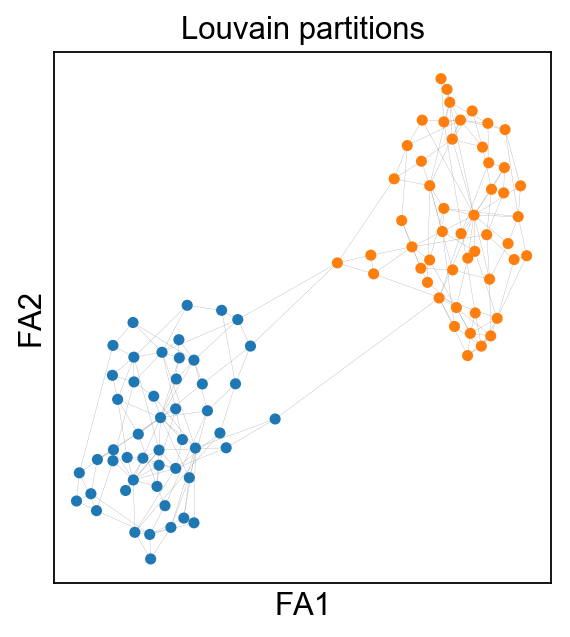

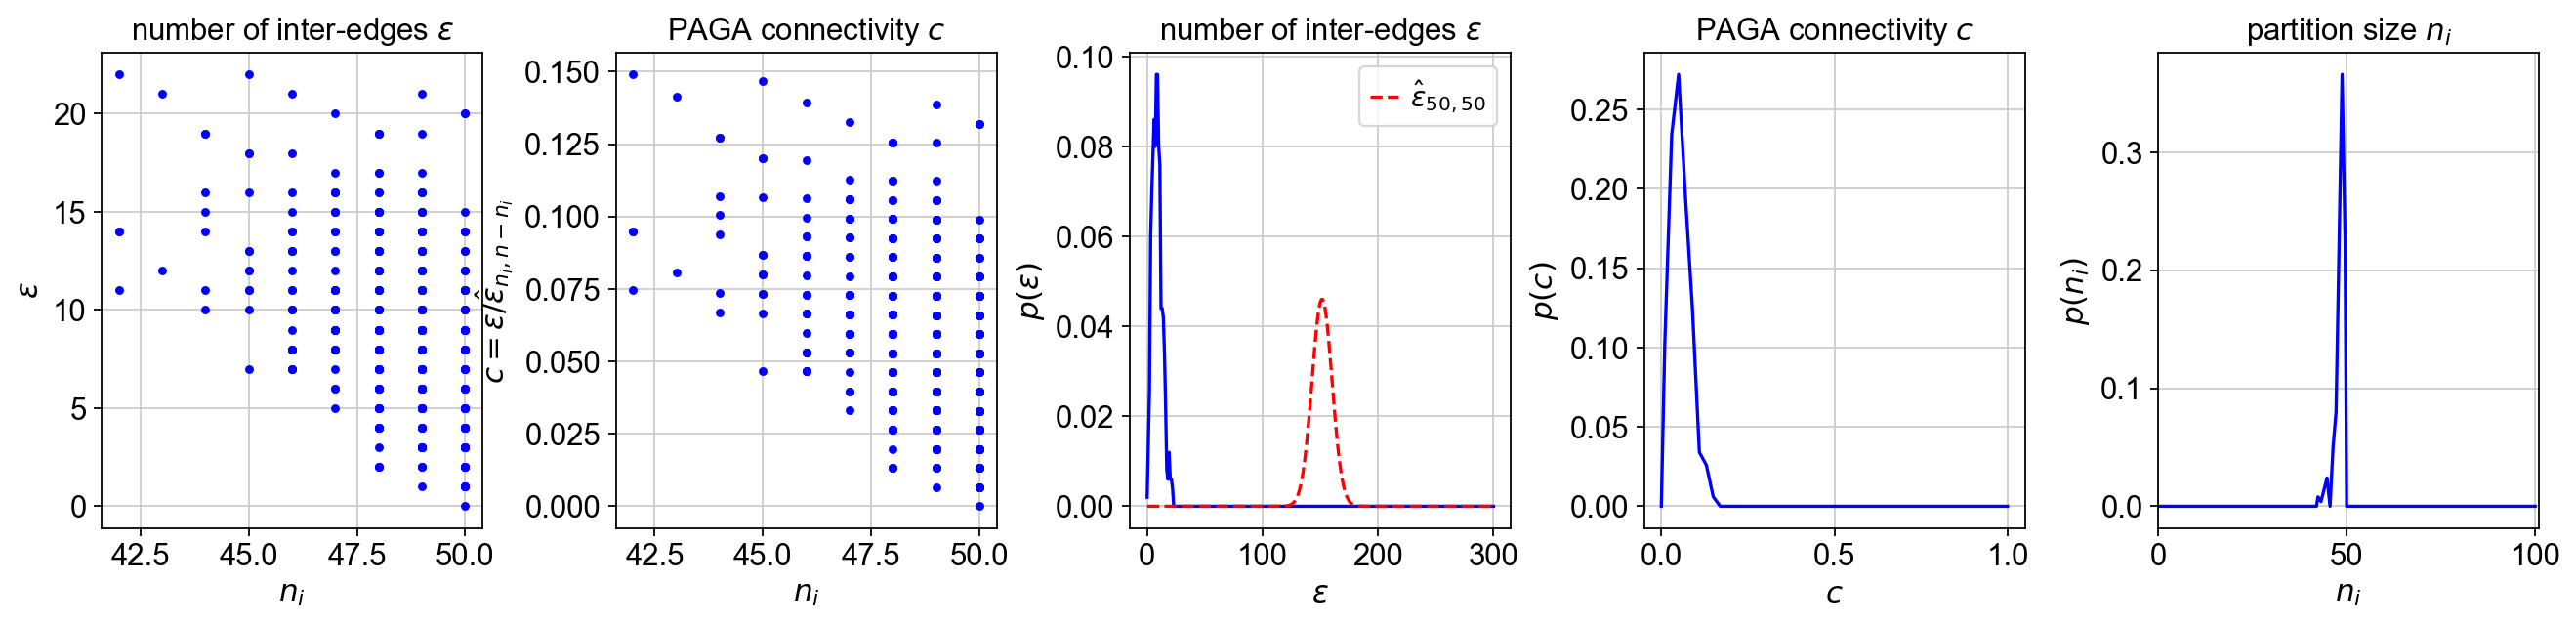

saving figure to file ./figures/draw_graph_fa_dist6.pdf


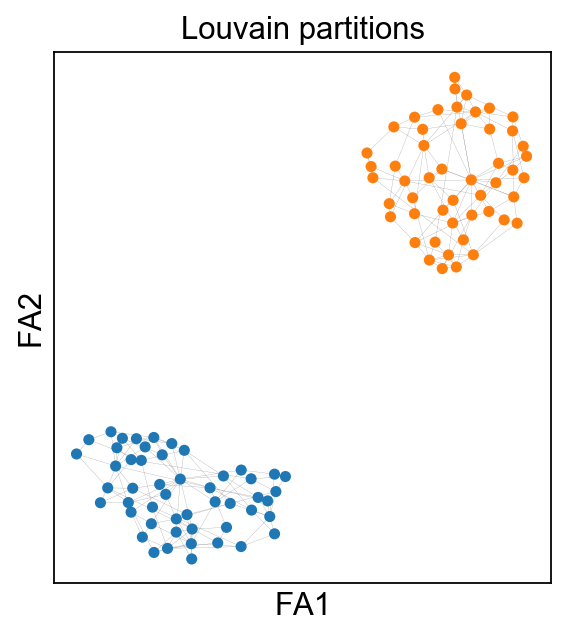

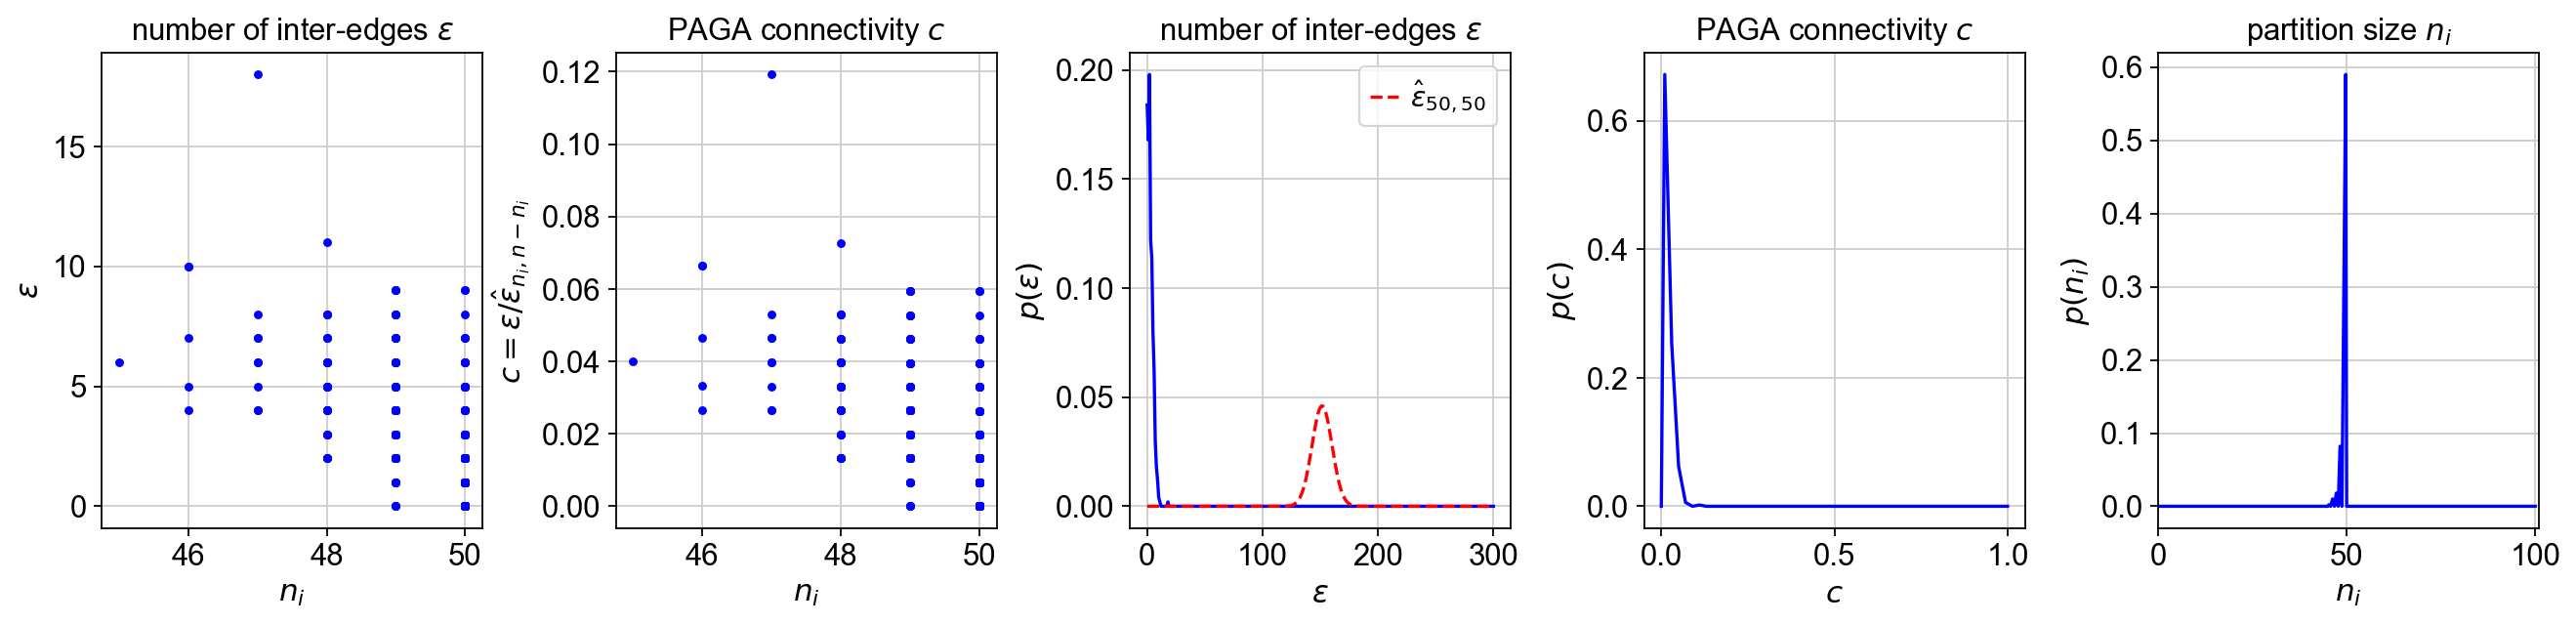

In [12]:
statistics = {'distance': [], 'connectivities': [], 'epsilon': [], 'ni': []}
cluster_dists = [0, 0, 2, 4, 5, 6]
resolutions = [0, 0.4, 0.4, 0.4, 0.4, 0.4]  # first one is random graph
for i, cluster_dist in enumerate(cluster_dists[:]):
    # plot scatter
    n_realizations = 1
    resolution = resolutions[i]
    figsuffix = '_dist{}'.format(cluster_dist) if resolution != 0 else '_random'
    estimate_probability(n, 0, n_neighbors, resolution=resolution, cluster_dist=cluster_dist)
    
    # run simulation
    n_realizations = 500
    result = estimate_probability(n, 0, n_neighbors, resolution=resolution, model='v1.2', return_all=True, cluster_dist=cluster_dist)
    epsilon_observed, epsilon_estim, conn_observed, conn_estim, conn_bins, ni_observed, ni_estim, ni_bins = result
    
    if resolution != 0:
        statistics['distance'] += len(conn_observed)*[cluster_dist]
        statistics['connectivities'] += conn_observed
        statistics['epsilon'] += epsilon_observed 
        statistics['ni'] += ni_observed 
    
    _, axs = pl.subplots(ncols=5, figsize=(20, 4), gridspec_kw=dict(wspace=0.35))
    pl.sca(axs[0])
    pl.title(r'number of inter-edges $\epsilon$')
    pl.plot(ni_observed, epsilon_observed, '.b')
    # plot also the predicted number of inter-edges
    # pl.errorbar(ni_observed,
    #             epsilon_hat_arbit_degree_knn(n, np.array(ni_observed), n_neighbors),
    #             yerr=sigma_hat_arbit_degree_knn(n, np.array(ni_observed), n_neighbors),
    #             fmt='.r', label=r'$\hat\epsilon_{n_i, n-n_i}$')
    # pl.legend(handlelength=1)    
    pl.ylabel(r'$\epsilon$')
    pl.xlabel(r'$n_i$')

    
    pl.sca(axs[1])
    pl.title(r'PAGA connectivity $c$')
    pl.plot(ni_observed, conn_observed, '.b')
    pl.ylabel(r'$c=\epsilon/\hat\epsilon_{n_i, n-n_i}$')
    pl.xlabel(r'$n_i$')
    
    pl.sca(axs[2])
    pl.title(r'number of inter-edges $\epsilon$')
    pl.plot(epsilon_estim, 'b',)
    pl.plot(p_pred_random, '--r', label=r'$\hat\epsilon_{50, 50}$')
    pl.ylabel(r'$p(\epsilon)$')
    pl.xlabel(r'$\epsilon$')
    pl.legend(handlelength=1)
    
    pl.sca(axs[3])
    pl.title(r'PAGA connectivity $c$')
    pl.plot(
        [0, conn_bins[0]] + list((conn_bins[:-1] + np.diff(conn_bins)/2)) + [conn_bins[-1], 1],
        [0, 0] + list(conn_estim) + [0, 0], 'b')    
    pl.ylabel(r'$p(c)$')
    pl.xlabel(r'$c$') 

    pl.sca(axs[4])
    pl.title(r'partition size $n_i$')
    pl.ylabel(r'$p(n_i)$')
    pl.plot(
        [0, ni_bins[0]] + list((ni_bins[:-1] + np.diff(ni_bins)/2)) + [ni_bins[-1], n],
        [0, 0] + list(ni_estim) + [0, 0], 'b')
    pl.xlabel(r'$n_i$')
    pl.xlim(0, n+1)
    filename = './figures/statistics_dist{}.pdf'.format(cluster_dist) if resolution != 0 else './figures/statistics_random.pdf'
    pl.savefig(filename, bbox_inches='tight')
    pl.show()

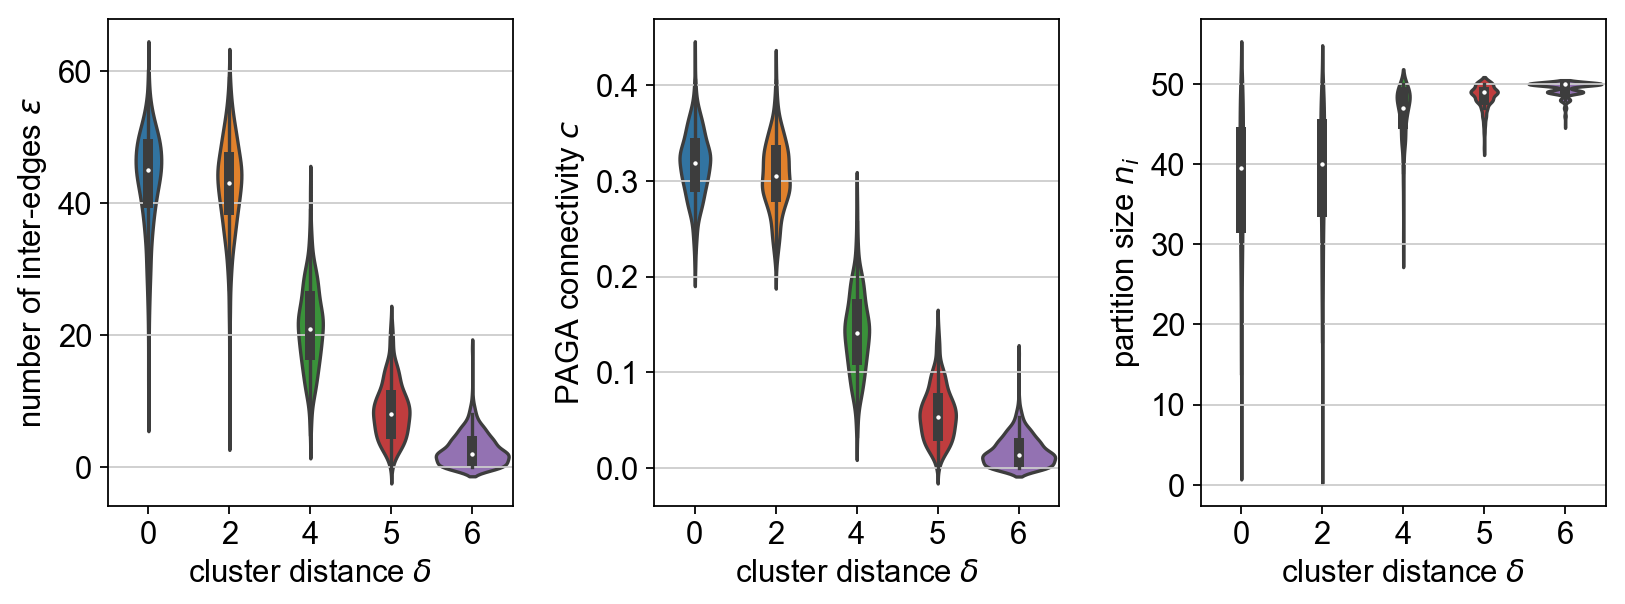

In [13]:
df = pd.DataFrame(statistics)
_, axs = pl.subplots(ncols=3, figsize=(12, 4), gridspec_kw=dict(wspace=0.35))
cols = ['epsilon', 'connectivities','ni']
labels = [r'number of inter-edges $\epsilon$', r'PAGA connectivity $c$', r'partition size $n_i$']
for iax, ax in enumerate(axs):
    pl.sca(ax)
    sns.violinplot(x='distance', y=cols[iax], data=df, width=0.9)
    pl.ylabel(labels[iax])
    pl.xlabel(r'cluster distance $\delta$')
pl.savefig('./figures/statistics.pdf', bbox_inches='tight')
pl.show()

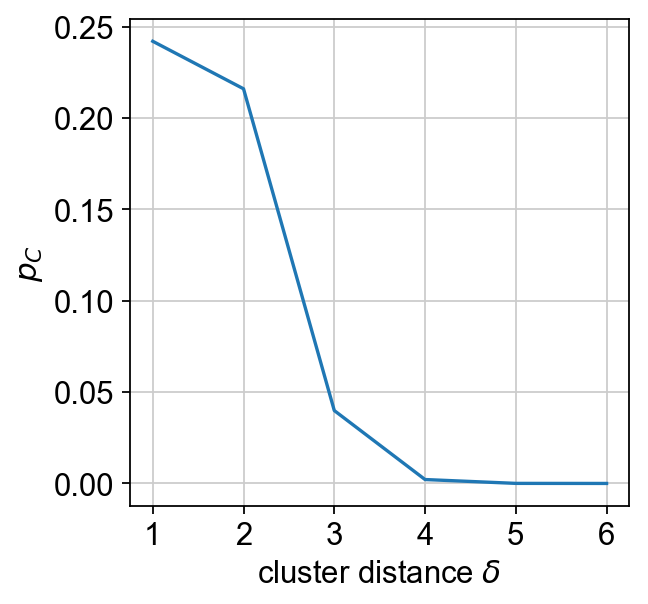

In [16]:
confs = np.array([norm.pdf(d) * d**2 for d in range(1, 7)])  # arbitrary factor from "fitting by eye"
pl.plot(range(1, 7), confs)
pl.xlabel(r'cluster distance $\delta$')
pl.ylabel(r'$p_C$')
pl.xticks(range(1, 7))
pl.savefig('./figures/two_blobs_approx.pdf', bbox_inches='tight')
pl.show()

## More than two clusters

... storing 'blobs' as categorical
saving figure to file ./figures/paga_compare_cluster_std4.pdf


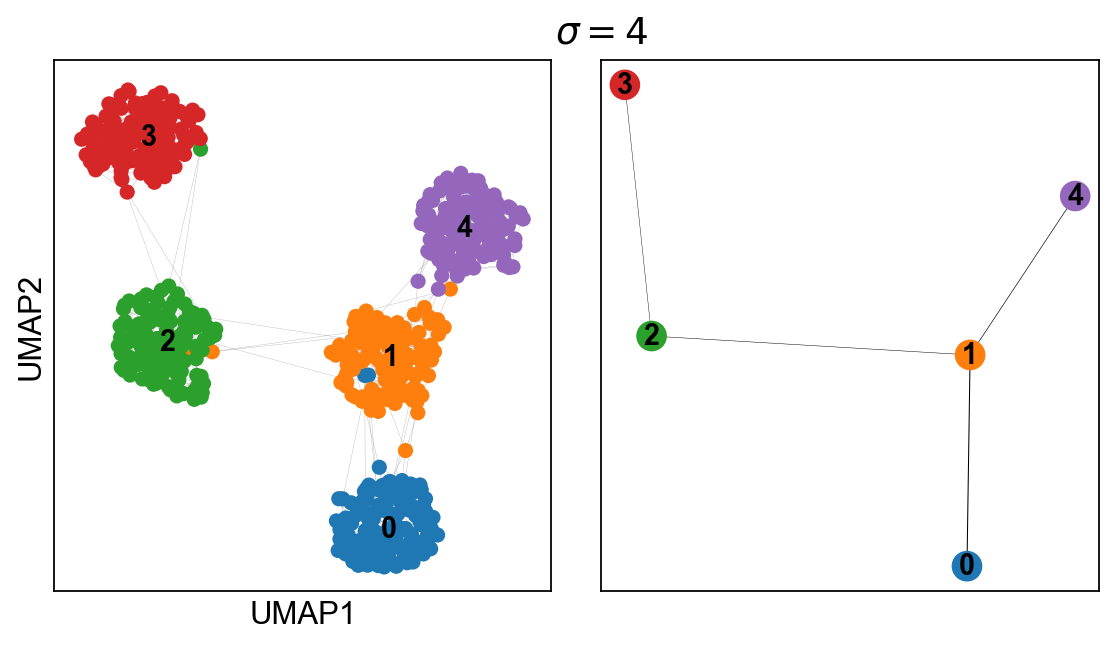

... storing 'blobs' as categorical
saving figure to file ./figures/paga_compare_cluster_std5.pdf


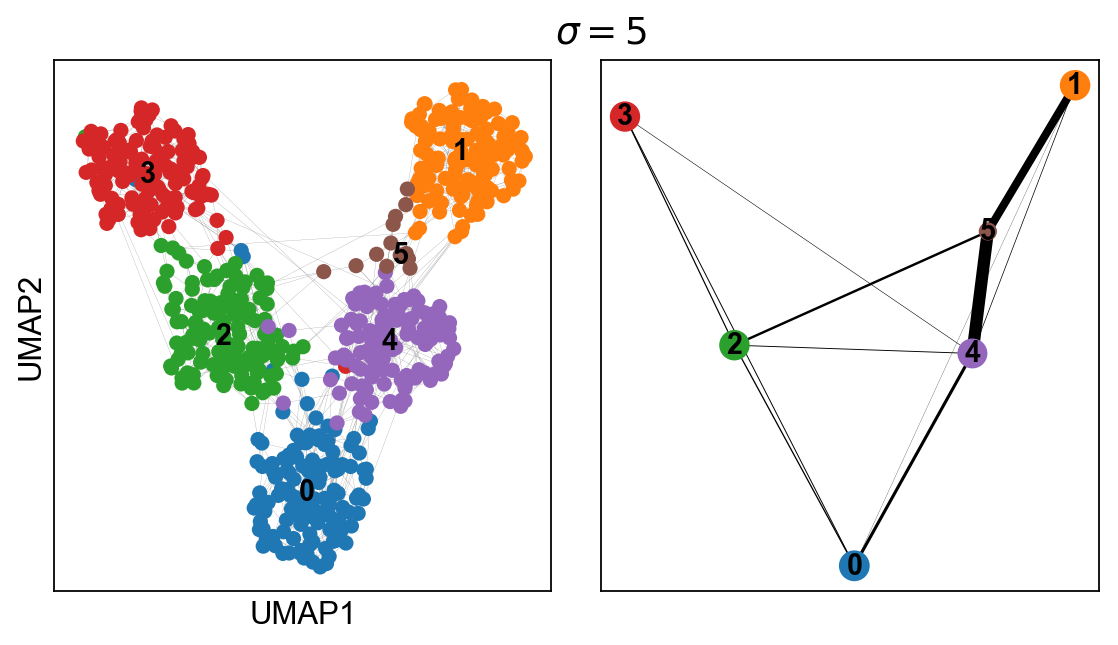

... storing 'blobs' as categorical
saving figure to file ./figures/paga_compare_cluster_std6.pdf


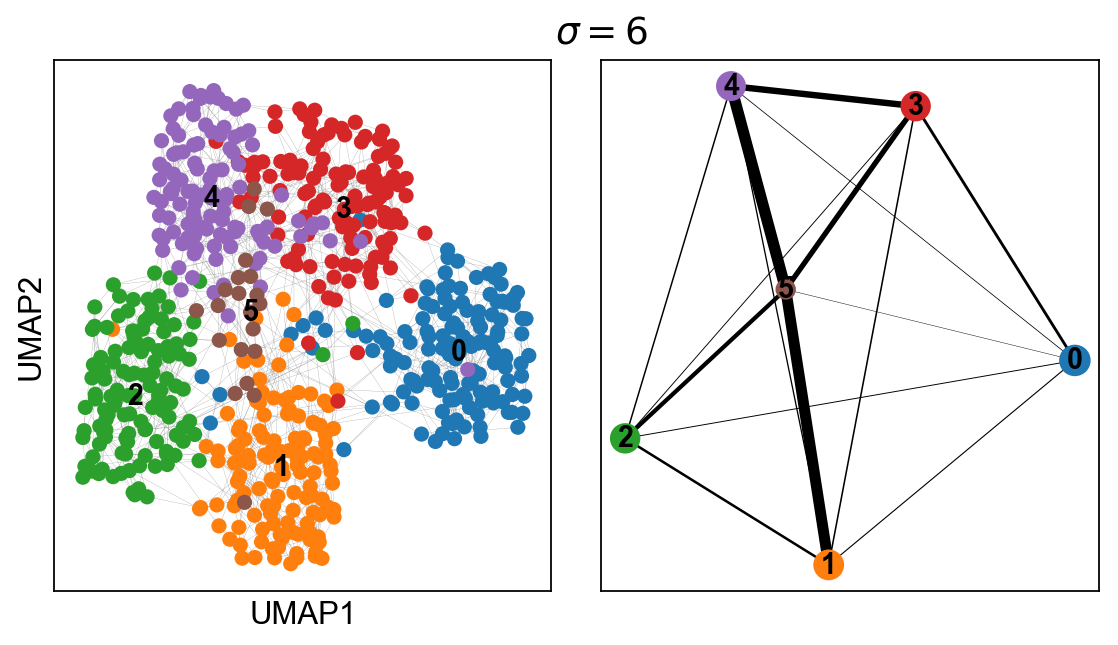

In [14]:
sc.settings.verbosity = 1
for std in [4, 5, 6]:
    adata = sc.datasets.blobs(cluster_std=std, n_centers=5)
    sc.pp.neighbors(adata, n_neighbors=5)
    sc.tl.umap(adata)    
    sc.tl.louvain(adata)
    sc.tl.paga(adata)
    sc.pl.paga_compare(
        adata,
        layout='circle',
        title=r'$\sigma={}$'.format(std),
        save='_cluster_std{}'.format(std))